In [1]:
'''
Monte Carlo Tree Search (MCTS) algorithm implementation and testing using an openAI gym enviroment. 
'''

'\nMonte Carlo Tree Search (MCTS) algorithm implementation and testing using an openAI gym enviroment. \n'

In [2]:
'''
We will test our Monte Carlo Tree Search algorithm (MCTS) using an openAI gym environment named "CartPole".
You can read more information about the environment at this link:
https://www.gymlibrary.ml/environments/classic_control/cart_pole/

Feel free to change the environment with other as you like, changing the game name variable, 
but keep in mind that for this MCTS implementation both Actions and Observation must be Discrete. 
'''

# uncomment these lines below if you get a runtime error of gym package not found
# change the path value using your actual gym path using the 'pip show gym' command
#import sys
#path = "c:\\users\\my\\anaconda3\\envs\\mcts\\lib\\site-packages"
#sys.path.append(path)

import numpy
import gym

GAME_NAME = 'CartPole-v0'

env = gym.make(GAME_NAME)
    
GAME_ACTIONS = env.action_space.n
GAME_OBS = env.observation_space.shape[0]

print('In the ' + GAME_NAME + ' environment there are: ' + str(GAME_ACTIONS) + ' possible actions.')
print('In the ' + GAME_NAME + ' environment the observation is composed of: ' + str(GAME_OBS) + ' values.')

env.reset()
env.close()

In the CartPole-v0 environment there are: 2 possible actions.
In the CartPole-v0 environment the observation is composed of: 4 values.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from math import *
import random

c = 1.0

class Node:
    
    '''
    The Node class represents a node of the MCTS tree. 
    It contains the information needed for the algorithm to run its search.
    '''

    def __init__(self, game, done, parent, observation, action_index):
          
        # child nodes
        self.child = None
        
        # total rewards from MCTS exploration
        self.T = 0
        
        # visit count
        self.N = 0        
                
        # the environment
        self.game = game
        
        # observation of the environment
        self.observation = observation
        
        # if game is won/loss/draw
        self.done = done

        # link to parent node
        self.parent = parent
        
        # action index that leads to this node
        self.action_index = action_index
        
        
    def getUCBscore(self):
        
        '''
        This is the formula that gives a value to the node.
        The MCTS will pick the nodes with the highest value.        
        '''
        
        # Unexplored nodes have maximum values so we favour exploration
        if self.N == 0:
            return float('inf')
        
        # We need the parent node of the current node 
        top_node = self
        if top_node.parent:
            top_node = top_node.parent
            
        # We use one of the possible MCTS formula for calculating the node value
        return (self.T / self.N) + c * sqrt(log(top_node.N) / self.N)
    
    
    def detach_parent(self):
        # free memory detaching nodes
        del self.parent
        self.parent = None
       
        
    def create_child(self):
        
        '''
        We create one children for each possible action of the game, 
        then we apply such action to a copy of the current node enviroment 
        and create such child node with proper information returned from the action executed
        '''
        
        if self.done:
            return
    
        actions = []
        games = []
        for i in range(GAME_ACTIONS): 
            actions.append(i)           
            new_game = deepcopy(self.game)
            games.append(new_game)
            
        child = {} 
        for action, game in zip(actions, games):
            observation, reward, done, _ = game.step(action)
            child[action] = Node(game, done, self, observation, action)                        
            
        self.child = child
                
            
    def explore(self):
        
        '''
        The search along the tree is as follows:
        - from the current node, recursively pick the children which maximizes the value according to the MCTS formula
        - when a leaf is reached:
            - if it has never been explored before, do a rollout and update its current value
            - otherwise, expand the node creating its children, pick one child at random, do a rollout and update its value
        - backpropagate the updated statistics up the tree until the root: update both value and visit counts
        '''
        
        # find a leaf node by choosing nodes with max U.
        
        current = self
        
        while current.child:

            child = current.child
            max_U = max(c.getUCBscore() for c in child.values())
            actions = [ a for a,c in child.items() if c.getUCBscore() == max_U ]
            if len(actions) == 0:
                print("error zero length ", max_U)                      
            action = random.choice(actions)
            current = child[action]
            
        # play a random game, or expand if needed          
            
        if current.N < 1:
            current.T = current.T + current.rollout()
        else:
            current.create_child()
            if current.child:
                current = random.choice(current.child)
            current.T = current.T + current.rollout()
            
        current.N += 1      
                
        # update statistics and backpropagate
            
        parent = current
            
        while parent.parent:
            
            parent = parent.parent
            parent.N += 1
            parent.T = parent.T + current.T           
            
            
    def rollout(self):
        
        '''
        The rollout is a random play from a copy of the environment of the current node using random moves.
        This will give us a value for the current node.
        Taken alone, this value is quite random, but, the more rollouts we will do for such node,
        the more accurate the average of the value for such node will be. This is at the core of the MCTS algorithm.
        '''
        
        if self.done:
            return 0        
        
        v = 0
        done = False
        new_game = deepcopy(self.game)
        while not done:
            action = new_game.action_space.sample()
            observation, reward, done, _ = new_game.step(action)
            v = v + reward
            if done:
                new_game.reset()
                new_game.close()
                break             
        return v

    
    def next(self):
        
        ''' 
        Once we have done enough search in the tree, the values contained in it should be statistically accurate.
        We will at some point then ask for the next action to play from the current node, and this is what this function does.
        There may be different ways on how to choose such action, in this implementation the strategy is as follows:
        - pick at random one of the node which has the maximum visit count, as this means that it will have a good value anyway.
        '''

        if self.done:
            raise ValueError("game has ended")

        if not self.child:
            raise ValueError('no children found and game hasn\'t ended')
        
        child = self.child
        
        max_N = max(node.N for node in child.values())
       
        max_children = [ c for a,c in child.items() if c.N == max_N ]
        
        if len(max_children) == 0:
            print("error zero length ", max_N) 
            
        max_child = random.choice(max_children)
        
        return max_child, max_child.action_index

In [4]:
from copy import deepcopy
import random

MCTS_POLICY_EXPLORE = 100 # MCTS exploring constant: the higher, the more reliable, but slower in execution time

def Policy_Player_MCTS(mytree):  

    '''
    Our strategy for using the MCTS is quite simple:
    - in order to pick the best move from the current node:
        - explore the tree starting from that node for a certain number of iterations to collect reliable statistics
        - pick the node that, according to MCTS, is the best possible next action
    '''
    
    for i in range(MCTS_POLICY_EXPLORE):
        mytree.explore()
        
    next_tree, next_action = mytree.next()
        
    # note that here we are detaching the current node and returning the sub-tree 
    # that starts from the node rooted at the choosen action.
    # The next search, hence, will not start from scratch but will already have collected information and statistics
    # about the nodes, so we can reuse such statistics to make the search even more reliable!
    next_tree.detach_parent()
    
    return next_tree, next_action

episode #1
reward_e 200.0
episode #2
reward_e 200.0
episode #3
reward_e 200.0
episode #4
reward_e 200.0
episode #5
reward_e 200.0
episode #6
reward_e 200.0
episode #7
reward_e 200.0
episode #8
reward_e 200.0
episode #9
reward_e 200.0
episode #10
reward_e 200.0


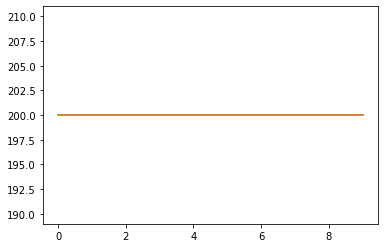

moving average: 200.0


In [5]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

episodes = 10
rewards = []
moving_average = []

'''
Here we are experimenting with our implementation:
- we play a certain number of episodes of the game
- for deciding each move to play at each step, we will apply our MCTS algorithm
- we will collect and plot the rewards to check if the MCTS is actually working.
- For CartPole-v0, in particular, 200 is the maximum possible reward. 
'''

for e in range(episodes):

    reward_e = 0    
    game = gym.make(GAME_NAME)
    observation = game.reset() 
    done = False
    
    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)
    
    print('episode #' + str(e+1))
    
    while not done:
    
        mytree, action = Policy_Player_MCTS(mytree)
        
        observation, reward, done, _ = game.step(action)  
                        
        reward_e = reward_e + reward
        
        #game.render() # uncomment this if you want to see your agent in action!
                
        if done:
            print('reward_e ' + str(reward_e))
            game.close()
            break
        
    rewards.append(reward_e)
    moving_average.append(np.mean(rewards[-100:]))
    
plt.plot(rewards)
plt.plot(moving_average)
plt.show()
print('moving average: ' + str(np.mean(rewards[-20:])))